In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima

In [2]:
# Load the data
from uwv.config import CBS80072NED, CBS_OPENDATA_PROCESSED_DATA_DIR, OUTPUT_DIR

cbs = pd.read_parquet(CBS_OPENDATA_PROCESSED_DATA_DIR / f"{CBS80072NED}.parquet")

2024-09-08 14:26:24.204 | INFO     | uwv.config:<module>:11 - PROJ_ROOT path is: C:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv


In [3]:
# Data Preprocessing
# Filter out rows where 'period_quarter_number' is 0
cbs = cbs[cbs['period_quarter_number'] != 0]

In [4]:
# Map quarters to months and create the 'date' column
cbs['month'] = cbs['period_quarter_number'].map({1: 1, 2: 4, 3: 7, 4: 10})
cbs['date'] = pd.to_datetime({'year': cbs['period_year'], 'month': cbs['month'], 'day': 1})

In [5]:
# Set this new 'date' column as the index
cbs.set_index('date', inplace=True)

In [6]:
# Filter data based on 'sbi_title'
sbi_code = 'T001081'  # Example: A-U Alle economische activiteiten
filtered_cbs = cbs[cbs['sbi'] == sbi_code]

In [7]:
# Filter the data to include only dates from 2008 to 2023
filtered_cbs = filtered_cbs.loc['2008-01-01':'2023-12-31']

In [8]:
# Set the frequency to quarterly
filtered_cbs.index.freq = 'QS'

In [9]:
# Drop any NaN values to clean the dataset
filtered_cbs = filtered_cbs.dropna()

In [10]:
# Ensure the 'sick_leave_percentage' column is in the correct format
filtered_cbs['sick_leave_percentage'] = filtered_cbs['sick_leave_percentage'].astype(float)

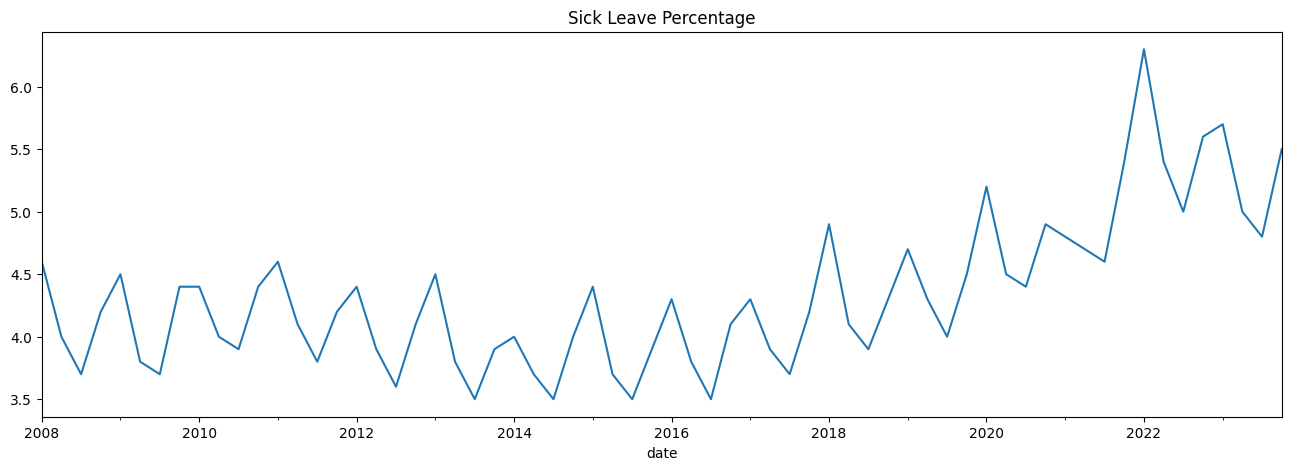

In [11]:
# Plotting Sick Leave Percentage
filtered_cbs['sick_leave_percentage'].plot(figsize=(16,5), title='Sick Leave Percentage')
plt.show()

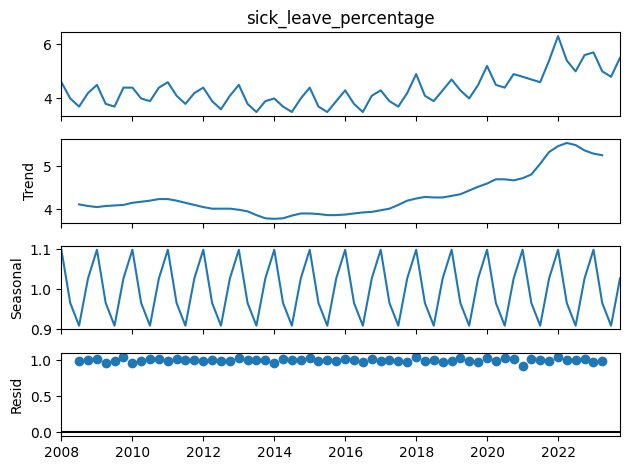

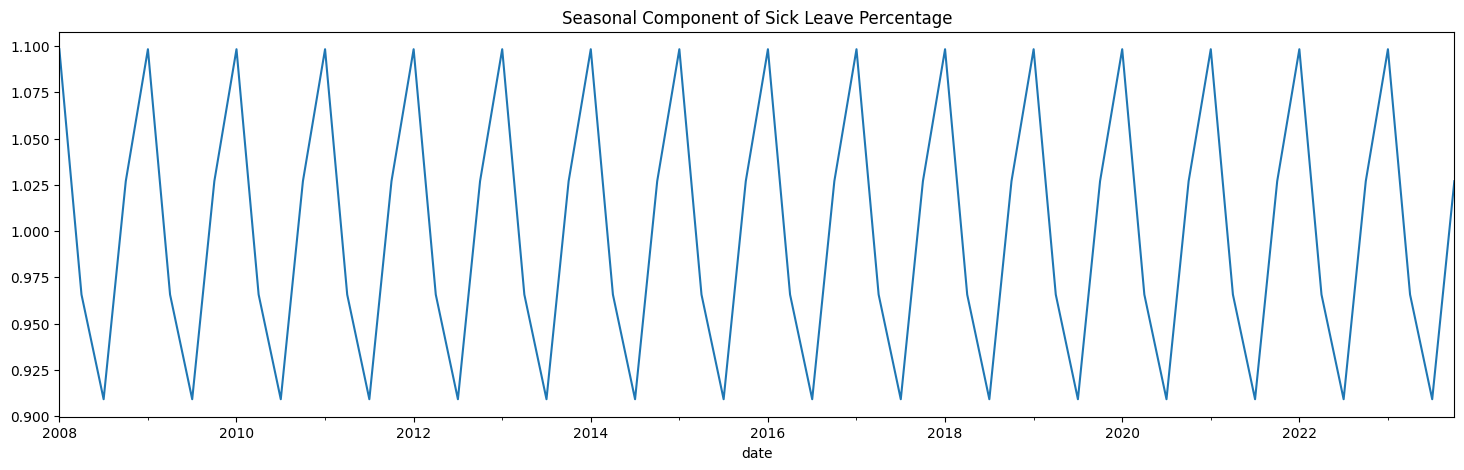

In [12]:
# Seasonal Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(filtered_cbs['sick_leave_percentage'], model='multiplicative')
result.plot()
plt.show()

result.seasonal.plot(figsize=(18,5), title='Seasonal Component of Sick Leave Percentage')
plt.show()

In [13]:
# Define Training and Test Sets
train = filtered_cbs.iloc[:-8]  # Use all but the last 8 quarters for training
test = filtered_cbs.iloc[-8:]   # Use the last 8 quarters for testing

In [14]:

# Auto ARIMA Suggestion
auto_arima(train['sick_leave_percentage'], seasonal=True, m=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   56
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 4)   Log Likelihood                  17.685
Date:                            Sun, 08 Sep 2024   AIC                            -29.370
Time:                                    14:26:42   BIC                            -23.574
Sample:                                01-01-2008   HQIC                           -27.155
                                     - 10-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4750      0.155     -3.057      0.002      -0.780      -0.170
ar.S.L4       -0.7218      0.145     -4.966      0.000      -1.007      -0.437
sigma2         0.0274      0.005      5.297      0.000       0.017       0.038
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.97
Prob(Q):                              0.97   Prob(JB):                         0.05
Heteroskedasticity (H):               2.10   Skew:                            -0.49
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
# Define the Function to Find the Best SARIMAX Model
def find_best_sarimax(train, p_values, d_values, q_values, P_values, D_values, Q_values, m):
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None
    best_model = None

In [16]:
# Define the Function to Find the Best SARIMAX Model
def find_best_sarimax(train, p_values, d_values, q_values, P_values, D_values, Q_values, m):
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None
    best_model = None

    # Iterate over all combinations of (p, d, q) and (P, D, Q)
    for p, d, q in product(p_values, d_values, q_values):
        for P, D, Q in product(P_values, D_values, Q_values):
            try:
                # Define the SARIMAX model
                model = SARIMAX(
                    train,
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, m),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                
                # Fit the model
                results = model.fit(disp=False)
                
                # Check if the current model has the best AIC
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
                    best_seasonal_order = (P, D, Q, m)
                    best_model = results
            except Exception as e:
                # Handle any errors during fitting
                print(f"Error with order {(p, d, q)} and seasonal order {(P, D, Q, m)}: {e}")
                continue

    print(f"Best SARIMAX order: {best_order}, seasonal order: {best_seasonal_order}, AIC: {best_aic}")
    return best_model

# Define ranges for the parameters
p = range(0, 3)     # p-values range from 0 to 2
d = range(0, 2)     # d-values range from 0 to 1
q = range(0, 3)     # q-values range from 0 to 2
P = range(0, 3)     # Seasonal P-values range from 0 to 2
D = range(0, 2)     # Seasonal D-values range from 0 to 1
Q = range(0, 3)     # Seasonal Q-values range from 0 to 2
m = 4               # Seasonal period is 4 (quarterly data)

In [17]:
# Find the Best Model
best_model = find_best_sarimax(train['sick_leave_percentage'], p, d, q, P, D, Q, m)

c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\base\model.py:

Best SARIMAX order: (0, 1, 1), seasonal order: (1, 1, 0, 4), AIC: -27.49681949336803


c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
# Evaluate the best model on the test set
start = len(train)
end = len(train) + len(test) - 1
predictions = best_model.predict(start=start, end=end).rename('SARIMAX Predictions')

In [19]:
# Calculate and print RMSE
rmse_value = rmse(test['sick_leave_percentage'], predictions)
print(f'RMSE: {rmse_value}')

RMSE: 0.386205101131955


In [20]:
# Calculate MAE for predictions
from sklearn.metrics import mean_absolute_error
mae_value = mean_absolute_error(test['sick_leave_percentage'], predictions)
print(f'MAE: {mae_value}')

MAE: 0.31480131652884136


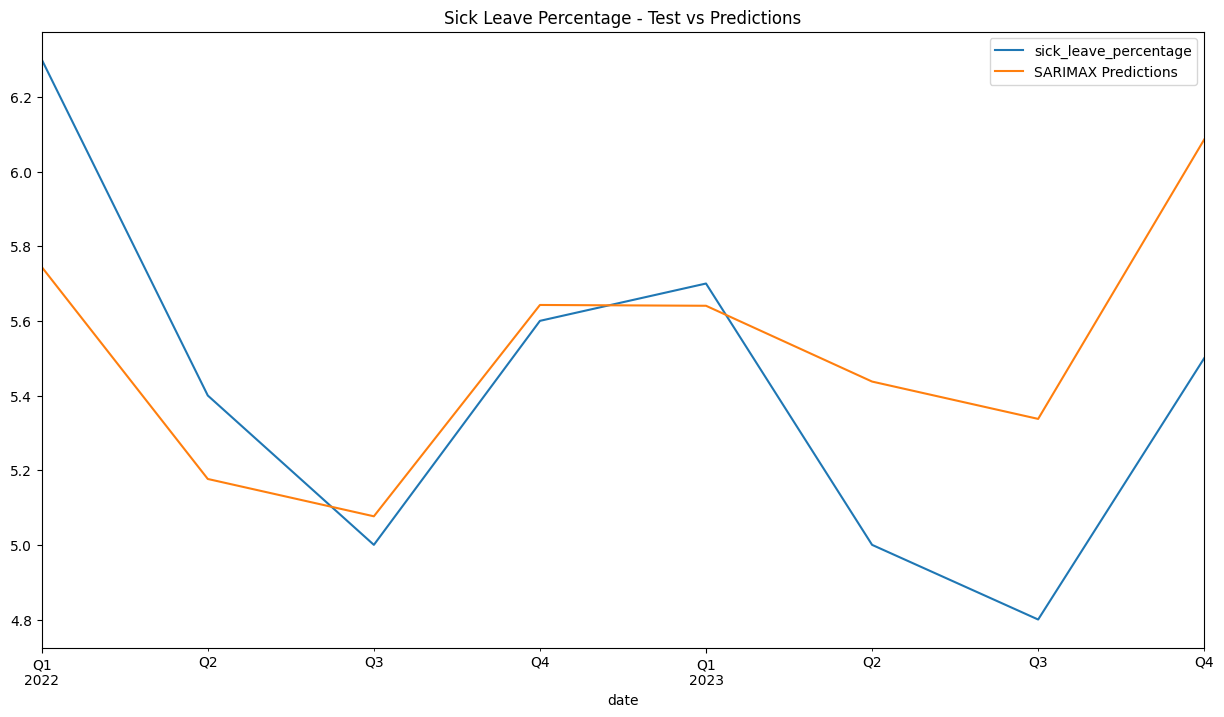

In [21]:
# Plotting the results
ax = test['sick_leave_percentage'].plot(legend=True, figsize=(15,8), title='Sick Leave Percentage - Test vs Predictions')
predictions.plot(legend=True)
plt.show()

In [22]:
# Train SARIMAX on the Full Dataset - Option 1
#final_model = SARIMAX(filtered_cbs['sick_leave_percentage'],
                      #order=(1, 0, 1),  # No differencing
                      #seasonal_order=(1, 0, 1, 4),  # Seasonal order with no differencing
                      #enforce_stationarity=False,
                      #enforce_invertibility=False)

#final_results = final_model.fit(maxiter=1000, method='lbfgs')

In [23]:
# Simplified SARIMAX model with reduced seasonal order - Option 2
#final_model = SARIMAX(filtered_cbs['sick_leave_percentage'],
                      #order=(1, 0, 1),  # No differencing
                      #seasonal_order=(0, 0, 0, 4),  # Simplified seasonal order
                      #enforce_stationarity=False,
                      #enforce_invertibility=False)

#final_results = final_model.fit(maxiter=1000, method='lbfgs')

In [24]:
# Adjusted SARIMAX model fitting with increased iterations and different optimization method - Option 3
final_model = SARIMAX(filtered_cbs['sick_leave_percentage'],
                      order=(1, 0, 1),
                      seasonal_order=(1, 0, 1, 4),
                      enforce_stationarity=False,
                      enforce_invertibility=False)

final_results = final_model.fit(maxiter=2000, method='powell', tol=1e-6)

# Check the results
print(final_results.summary())

# Inspect optimization details if convergence warning persists
print(final_results.mle_retvals)


c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method powell is: xtol, ftol, maxfun, start_direc. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


Optimization terminated successfully.
         Current function value: -0.201330
         Iterations: 5
         Function evaluations: 284
                                     SARIMAX Results                                     
Dep. Variable:             sick_leave_percentage   No. Observations:                   64
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 4)   Log Likelihood                  12.885
Date:                           Sun, 08 Sep 2024   AIC                            -15.770
Time:                                   14:27:38   BIC                             -5.468
Sample:                               01-01-2008   HQIC                           -11.757
                                    - 10-01-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

In [25]:
# Forecast Future Values
forecast_steps = 8  # Number of quarters to forecast
fcast = final_results.predict(len(filtered_cbs), len(filtered_cbs) + forecast_steps - 1).rename('SARIMAX Forecast')


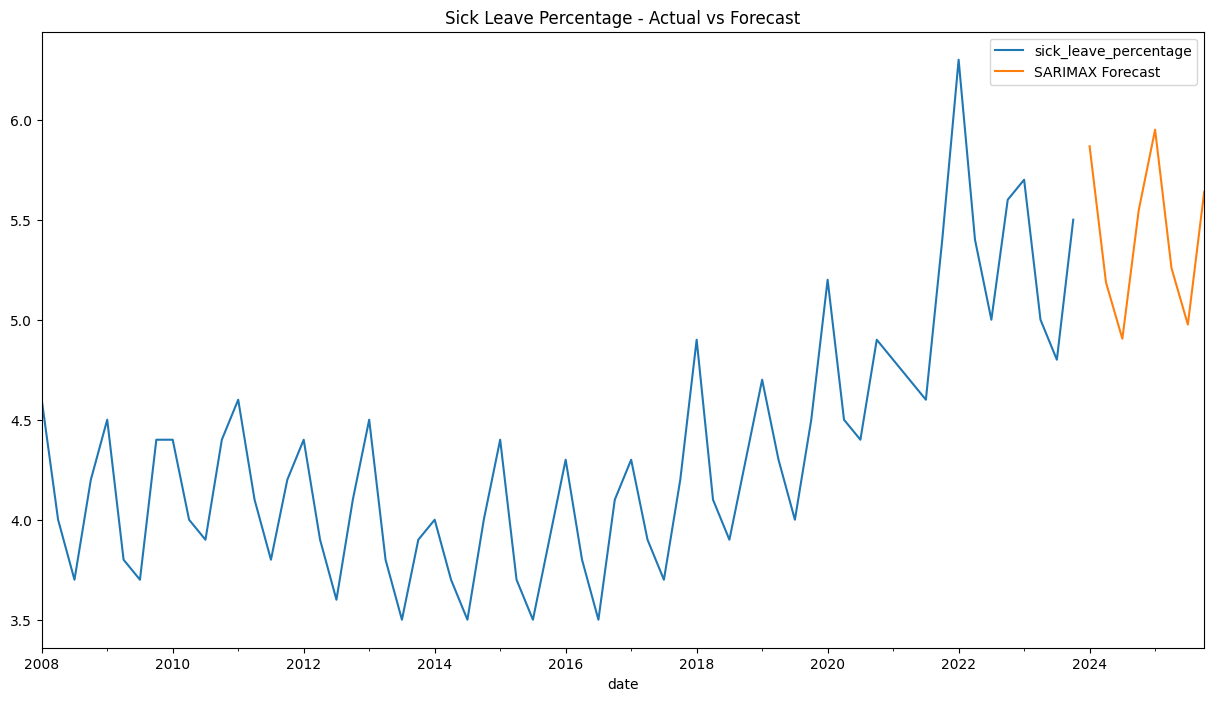

In [26]:
# Plotting the forecast
ax = filtered_cbs['sick_leave_percentage'].plot(legend=True, figsize=(15,8), title='Sick Leave Percentage - Actual vs Forecast')
fcast.plot(legend=True)

plt.show()